# Dwell time by access method

This notebook implements the computation of the total

- Number of clicks per session,
- Dwell times, 
- The percentage of clicks to which a dwell time can be associated (How many clicks "have a dwell time")

with and without grouping the results by access method. 

Access method is computed based on the following data sources:
- Search logs, i.e. `event.mediawiki_cirrussearch_request` (`emcr`)
- `discovery.query_clicks_daily` (`dqcd`)

using `'org.wikimedia.analytics.refinery.hive.GetAccessMethodUDF'` with the following inputs: 

- user agent = `http.request_headers["user-agent"]`
- URI host = `clicks[0].referer` (extracted using the regex `:[www.]?([a-zA-Z0-9.]+`)

By observing the data, it was noted that multiple consecutive clicks to the same page (indicated by the `page id` attribute) and from the same referrer were being made among several sessions. Consecutive requests to the same page id and from the same referrer were filtered from the sessions confirming the hypothesis.

We recall that given 2 consecutive clicks `c` and `c'` on search results within a user session, the corresponding dwell time is defined as  
> `dw(c,c')=c'.timestamp-c.timestamp`. 

## Create spark session

In [1]:
import os, sys
import re, math
from user_agents import parse # from https://pypi.org/project/user-agents/
import time
from itertools import groupby 

import findspark
findspark.init('/usr/lib/spark2')
from pyspark.sql import SparkSession
from pyspark.sql import functions as F, types as T, Window
import wmfdata.spark as wmfspark

# defining the spark session
spark_config = {}
spark = wmfspark.get_session(
    app_name='Pyspark notebook - dwell time by a. method | bscarone (WMF)', 
    type='regular'
    # extra_settings=spark_config
)
spark

You are using wmfdata v1.3.2, but v1.3.3 is available.

To update, run `pip install --upgrade git+https://github.com/wikimedia/wmfdata-python.git@release --ignore-installed`.

To see the changes, refer to https://github.com/wikimedia/wmfdata-python/blob/release/CHANGELOG.md
PySpark executors will use /usr/lib/anaconda-wmf/bin/python3.


PYSPARK_PYTHON=/usr/lib/anaconda-wmf/bin/python3


SLF4J: Class path contains multiple SLF4J bindings.
SLF4J: Found binding in [jar:file:/usr/lib/spark2/jars/slf4j-log4j12-1.7.16.jar!/org/slf4j/impl/StaticLoggerBinder.class]
SLF4J: Found binding in [jar:file:/usr/lib/hadoop/lib/slf4j-log4j12-1.7.25.jar!/org/slf4j/impl/StaticLoggerBinder.class]
SLF4J: See http://www.slf4j.org/codes.html#multiple_bindings for an explanation.
SLF4J: Actual binding is of type [org.slf4j.impl.Log4jLoggerFactory]
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/08/12 23:51:53 WARN SparkConf: Note that spark.local.dir will be overridden by the value set by the cluster manager (via SPARK_LOCAL_DIRS in mesos/standalone/kubernetes and LOCAL_DIRS in YARN).
22/08/12 23:51:53 WARN Utils: Service 'sparkDriver' could not bind on port 12000. Attempting port 12001.
22/08/12 23:51:53 WARN Utils: Service 'sparkDriver' could not bind on port 12001. Attempting port 12002.
22/08/12 23:51:53 

In [2]:
print('PySpark Version :'+spark.version)

PySpark Version :2.4.4


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go

# Dweel time by access_method (from `discovery.query_clicks_daily`)

In [3]:
@F.udf(returnType='array<int>')
def dwell_time(clicks):
    n = len(clicks)
    i = 0
    # sort clicks asc by timestamp 
    clicks.sort(key=lambda x: x.timestamp)
    dwell_times = []
    # single_clicks = 0
    while i <= n-1:
        if i<=n-2:
            dw = clicks[i+1]["timestamp"]-clicks[i]["timestamp"]
            dwell_times.append(dw)
        # else:
        #     single_clicks += 1
        i += 1
    return dwell_times#, single_clicks

In [4]:
# import function to retrive access_method
spark.sql("ADD JAR /srv/deployment/analytics/refinery/artifacts/refinery-hive-shaded.jar").show()
spark.sql("CREATE TEMPORARY FUNCTION get_access_method as 'org.wikimedia.analytics.refinery.hive.GetAccessMethodUDF'")

+------+
|result|
+------+
|     0|
+------+



DataFrame[]

In [25]:
# Previous wrongly uri_hots extraction: CONCAT(normalized_host.project,'.',normalized_host.project_class,'.',normalized_host.tld) as uri_host 
def get_dwell_times_discovery_with_amethod(year, month, day):

    # Retrieve access_method
    q_amethod = f'''
        WITH query_clicks_daily_aux AS(
            SELECT session_id, clicks, http.request_headers["user-agent"] as user_agent,
            regexp_extract(clicks[0].referer,":\/\/[www.]?([\-a-zA-Z0-9.]+)",1) as uri_host
            FROM event.mediawiki_cirrussearch_request emcr INNER JOIN discovery.query_clicks_daily dqcd
                ON  emcr.search_id = dqcd.request_set_token
            WHERE 
                dqcd.year = {year}  AND dqcd.month = {month} AND dqcd.day BETWEEN {day} and {day+6}
                AND emcr.year = {year}  AND emcr.month = {month} AND emcr.day BETWEEN {day} and {day+6}
        )
        SELECT session_id, clicks, get_access_method(uri_host, user_agent) as access_method
        FROM query_clicks_daily_aux
    '''
    df_amethod = spark.sql(q_amethod)

    # Collect clicks per session
    # The click lists from the same session need to be concatenated
    df_amethod_2 = df_amethod.withColumn("clicks", F.explode("clicks"))
    df_amethod_concat = df_amethod_2.groupBy("session_id","access_method").agg(F.collect_list("clicks").alias("clicks"))
    df_amethod_concat_len = df_amethod_concat.withColumn("size_clicks", F.size("clicks")).drop("clicks")
    df_amethod_concat_len.show(20, False)
    df_clicks_distr = df_amethod_concat_len.groupBy("size_clicks","access_method").count()
    
    df_clicks_distr.orderBy(F.col("size_clicks").asc()).show(20,False) # order criteria: desc() or asc()
    cnt_sessions_clicks = df_amethod_concat.count()
    print(f"Total nr. of sessions (before computing dw): {cnt_sessions_clicks}")
    cnt_1click_sessions = df_amethod_concat.where(F.size("clicks") == 1).count()
    print(f"Total nr. of sessions with 1 click (before computing dw): {cnt_1click_sessions}")
    
    # Compute dwell times per session
    df_amethod_dw = df_amethod_concat.withColumn("dwell_times", dwell_time(F.col("clicks"))) 
    # Count empty lists (at most 1 click)
    # cnt_empty_dw = df_amethod_dw.select("*").where(F.size(F.col("dwell_times"))==0).count() # verify, when |clicks|<=1 => dw = [] => size(dw) = 0

    # print("Nr. of sessions with at most 1 click:", cnt_empty_dw, f"({cnt_empty_dw*100/cnt_sessions}%)")
    # Filter empty lists (at most 1 click)
    df_amethod_dw_ne = df_amethod_dw.select("session_id","access_method","dwell_times").filter(F.size(F.col("dwell_times"))>0)
    
    # write data to hdfs
    today = datetime.date.today()
    df_amethod_concat_len.write.mode("overwrite").parquet(f'''dwell-time/df_sessionid_amethod_sizeclicks_{day}-{day+6}{month}{year}_r{today.day}{today.month}{today.year}.parquet''')
    df_amethod_dw_ne.write.mode("overwrite").parquet(f'''dwell-time/df_sessionid_amethod_nonempty_dwelltimes_{day}-{day+6}{month}{year}_r{today.day}{today.month}{today.year}.parquet''')
    df_clicks_distr.write.mode("overwrite").parquet(f'''dwell-time/df_clicks_distr_{day}-{day+6}{month}{year}_r{today.day}{today.month}{today.year}.parquet''')
    
    return df_amethod_concat_len,df_amethod_dw_ne,df_clicks_distr

In [42]:
def plot_dwell_times_discovery_by_amethod(df_dw, bins, timerange, access_method, day, month, year, is_filtered):
        
    df_amethod = df_dw.where(F.col("access_method")==access_method).select("dwell_times")
    # df_amethod.show()
    bins = list(range(bins))
    bins[-1] = bins[-1]-0.01 # last interval is not half-closed, so it generates a spike otherwise
    df_amethod_dw_ne_total = df_amethod.withColumn("dwell_times", F.explode("dwell_times")).toPandas()
    
    n = df_amethod_dw_ne_total.shape[0]
    print(f'''Total dwell times - {access_method}''',n)
    try:
        ws = [1/n]*n
    except:
        ws = None
        
    ax = df_amethod_dw_ne_total.hist(column="dwell_times",bins=bins,range=timerange,weights=ws,figsize=(10,10))
    plt.title("Dwell time (discovery.query_clicks_daily) - {} on {}-{}/{}/{}".format(access_method,day,day+6,month,year), fontsize = 18)
    plt.xlabel("Dwell time (in seconds)", fontsize=16)
    plt.xticks(fontsize=14)
    plt.ylabel("% of total", fontsize=16)
    plt.yticks(fontsize=14)
    
    if is_filtered:
        plt.savefig(f'/home/bscarone/search-metrics/dwell-time/outputs/dwell_times_{access_method}_{day}-{day+6}{month}{year}_{timerange[0]}-{timerange[1]}_filtered.pdf')
    else:
        plt.savefig(f'/home/bscarone/search-metrics/dwell-time/outputs/dwell_times_{access_method}_{day}-{day+6}{month}{year}_{timerange[0]}-{timerange[1]}.pdf')


In [37]:
def plot_click_dist_discovery_by_amethod(df_clicks_len, bins, timerange, access_method, day, month, year):
    
    df_clicks_len_amethod = df_clicks_len.where((F.col("access_method")==access_method)) # & (F.col("size_clicks") <= 30)
    pd_df_clicks_len_amethod = df_clicks_len_amethod.toPandas()

    # pd_df_clicks_len_amethod.hist(column="size_clicks",edgecolor="yellow",figsize=(10,10),log=True) # alternative for log scale
    pd_df_clicks_len_amethod.hist(column="size_clicks",edgecolor="yellow",figsize=(10,10))
    # plt.title(f"Nr. of clicks per session - {access_method} on {day}-{day+6}/{month}/{year} (log scale)", fontsize = 18) # alternative for log scale
    plt.title(f"Nr. of clicks per session - {access_method} on {day}-{day+6}/{month}/{year}", fontsize = 18)
    plt.xlabel("Nr. of clicks", fontsize=16)
    plt.xticks(fontsize=14)
    plt.ylabel("Nr. of sessions", fontsize=16)
    plt.yticks(fontsize=14)
    # plt.savefig(f'/home/bscarone/search-metrics/dwell-time/outputs/clicks_dist_{access_method}_{day}-{day+6}{month}{year}_full_log.pdf')
    plt.savefig(f'/home/bscarone/search-metrics/dwell-time/outputs/clicks_dist_{access_method}_{day}-{day+6}{month}{year}_full.pdf')
    
    bins_clicks = list(range(0,21,1))
    bins_clicks[-1] = bins_clicks[-1]-0.01
    # pd_df_clicks_len_amethod.hist(column="size_clicks",bins=bins_clicks,edgecolor="yellow",range=(0,200),figsize=(10,10),log=True)
    pd_df_clicks_len_amethod.hist(column="size_clicks",bins=bins_clicks,edgecolor="yellow",range=(0,200),figsize=(10,10))
    # plt.title(f"Nr. of clicks per session - {access_method} on {day}-{day+6}/{month}/{year} (log scale)", fontsize = 18)
    plt.title(f"Nr. of clicks per session - {access_method} on {day}-{day+6}/{month}/{year}", fontsize = 18)
    plt.xlabel("Nr. of clicks", fontsize=16)
    plt.xticks(fontsize=14)
    plt.ylabel("Nr. of sessions", fontsize=16)
    plt.yticks(fontsize=14)
    # plt.savefig(f'/home/bscarone/search-metrics/dwell-time/outputs/clicks_dist_{access_method}_{day}-{day+6}{month}{year}_{timerange[0]}-{timerange[1]}_log.pdf')
    plt.savefig(f'/home/bscarone/search-metrics/dwell-time/outputs/clicks_dist_{access_method}_{day}-{day+6}{month}{year}_{timerange[0]}-{timerange[1]}.pdf')
    
    # pd_df_clicks_dist_amethod[1<pd_df_clicks_dist_amethod["size_clicks"]<=25].sort_index().plot.bar(x="size_clicks", y="count", sort=True, figsize=(20, 10))
    # plt.savefig(f'/home/bscarone/search-metrics/dwell-time/outputs/clicks_dist_bar_{access_method}_{day}-{day+6}{month}{year}_{timerange[0]}-{timerange[1]}.pdf')


In [19]:
# Ensure function dwell_time is defined
df_clicks_len, df_dw, df_clicks_distr = get_dwell_times_discovery_with_amethod(2022, 7, 4)

+--------------------------------------------+-------------+-----------+
|session_id                                  |access_method|size_clicks|
+--------------------------------------------+-------------+-----------+
|2022_7_10_0048a7ef78db0f9be593fddd11fcb78d_1|mobile web   |1          |
|2022_7_10_005cb546f789455ecec16a23c8480052_0|desktop      |1          |
|2022_7_10_005e541f128810d6cd7269f82958393c_0|mobile web   |1          |
|2022_7_10_008e63179c2c440d43b6230808364cfe_0|mobile web   |1          |
|2022_7_10_00ab958fa8dab40804238314a798f6fa_1|mobile web   |1          |
|2022_7_10_00d43202a23e14e7f1028b20ed814872_0|mobile web   |3          |
|2022_7_10_01121147c158e3af0aa2ea8e8f68393d_1|mobile web   |1          |
|2022_7_10_0128f3c4b0311ff03c6b92d37bb96da6_1|mobile web   |1          |
|2022_7_10_0136a75caea7c81af4e986cec2937ef7_0|mobile web   |1          |
|2022_7_10_0187f65a652a2dfd20d4afec7dc519b1_0|desktop      |1          |
|2022_7_10_01acfe7e8a4766ba722e60de5a243263_0|deskt

+-----------+-------------+-------+
|size_clicks|access_method|count  |
+-----------+-------------+-------+
|1          |desktop      |1735380|
|1          |mobile web   |1144345|
|2          |mobile web   |240080 |
|2          |desktop      |229996 |
|3          |desktop      |61938  |
|3          |mobile web   |67121  |
|4          |desktop      |24643  |
|4          |mobile web   |26736  |
|5          |mobile web   |13339  |
|5          |desktop      |12075  |
|6          |desktop      |6986   |
|6          |mobile web   |7313   |
|7          |mobile web   |4737   |
|7          |desktop      |4349   |
|8          |desktop      |2850   |
|8          |mobile web   |3115   |
|9          |desktop      |1996   |
|9          |mobile web   |2156   |
|10         |mobile web   |1631   |
|10         |desktop      |1478   |
+-----------+-------------+-------+
only showing top 20 rows



[Stage 40:>                                                     (0 + 164) / 256]22/07/29 22:36:03 ERROR TransportClient: Failed to send RPC RPC 5429685736601099115 to /10.64.53.8:43498: java.nio.channels.ClosedChannelException
java.nio.channels.ClosedChannelException
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(...)(Unknown Source)
22/07/29 22:36:03 WARN BlockManagerMasterEndpoint: Error trying to remove broadcast 61 from block manager BlockManagerId(552, an-worker1136.eqiad.wmnet, 36211, None)
java.io.IOException: Failed to send RPC RPC 5429685736601099115 to /10.64.53.8:43498: java.nio.channels.ClosedChannelException
	at org.apache.spark.network.client.TransportClient$RpcChannelListener.handleFailure(TransportClient.java:362)
	at org.apache.spark.network.client.TransportClient$StdChannelListener.operationComplete(TransportClient.java:339)
	at io.netty.util.concurrent.DefaultPromise.notifyListener0(DefaultPromise.java:507)
	at io.netty.util.concurrent.DefaultPromise.notif

Total nr. of sessions (before computing dw): 3605793


Total nr. of sessions with 1 click (before computing dw): 2879725


[Stage 55:======>       (96 + 17) / 196][Stage 56:>           (70 + 175) / 3908]22/07/29 22:52:10 ERROR YarnScheduler: Lost executor 532 on an-worker1139.eqiad.wmnet: Container killed by YARN for exceeding memory limits.  8.8 GB of 8.8 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead or disabling yarn.nodemanager.vmem-check-enabled because of YARN-4714.
22/07/29 22:52:10 WARN YarnSchedulerBackend$YarnSchedulerEndpoint: Requesting driver to remove executor 532 for reason Container killed by YARN for exceeding memory limits.  8.8 GB of 8.8 GB physical memory used. Consider boosting spark.yarn.executor.memoryOverhead or disabling yarn.nodemanager.vmem-check-enabled because of YARN-4714.
22/07/29 22:52:10 WARN TaskSetManager: Lost task 463.0 in stage 56.0 (TID 54530, an-worker1139.eqiad.wmnet, executor 532): ExecutorLostFailure (executor 532 exited caused by one of the running tasks) Reason: Container killed by YARN for exceeding memory limits.  8.8 GB of 8.8 G

In [20]:
cnt_desk_sessions = df_clicks_len.where(F.col("access_method")=="desktop").count()
print(f'''Total nr. of desktop sessions is {cnt_desk_sessions}''')

[Stage 63:==================================================>  (244 + 12) / 256]

Total nr. of desktop sessions is 2088492


In [21]:
cnt_mb_sessions = df_clicks_len.where(F.col("access_method")=="mobile web").count()
print(f'''Total nr. of mobile web sessions is {cnt_mb_sessions}''')

[Stage 67:=====================================================>(255 + 1) / 256]

Total nr. of mobile web sessions is 1517301


In [10]:
# discarded
def plot_click_dist_discovery_by_amethod_barchart(df_clicks_dist, max_val, access_method, day, month, year):
    df_clicks_dist_amethod = df_clicks_len.where((F.col("access_method")==access_method) & (F.col("size_clicks") <= max_val)) 
    pd_df_clicks_dist_amethod = df_clicks_len_amethod.toPandas()
    
    pd_df_clicks_dist_amethod.sort_values(["size_clicks"], inplace=True)
    pd_df_clicks_dist_amethod.plot.bar(x="size_clicks", y="count", figsize=(20, 10))
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)
    plt.title(f"Nr. of clicks per session - {access_method} on {day}-{day+6}/{month}/{year}")
    plt.xlabel("Nr. of clicks")
    plt.ylabel("Nr. of sessions")
    

In [43]:
# df_clicks_len.where(F.col("access_method")=="desktop").toPandas().hist(column="size(clicks)",edgecolor="yellow",figsize=(10,10))
df_dw = spark.read.parquet('dwell-time/df_sessionid_amethod_nonempty_dwelltimes_4-1072022_r182022.parquet')

In [ ]:
df_dw.show()

Total dwell times - desktop 719425


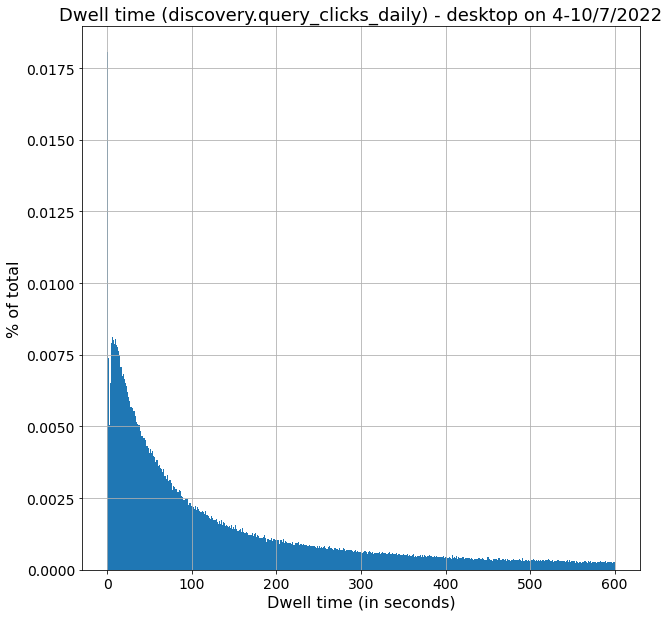

In [44]:
plot_dwell_times_discovery_by_amethod(df_dw, 601, (0,600), "desktop", 4, 7, 2022, False)

Total dwell times - desktop 719425


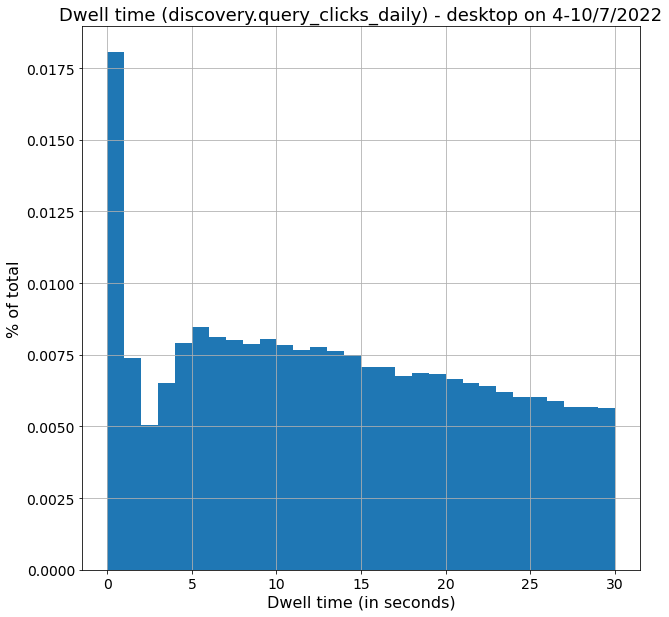

In [45]:
# try:
plot_dwell_times_discovery_by_amethod(df_dw, 31, (0,30), "desktop", 4, 7, 2022, False)
#     print("Plotting fail")

Total dwell times - mobile web 743539


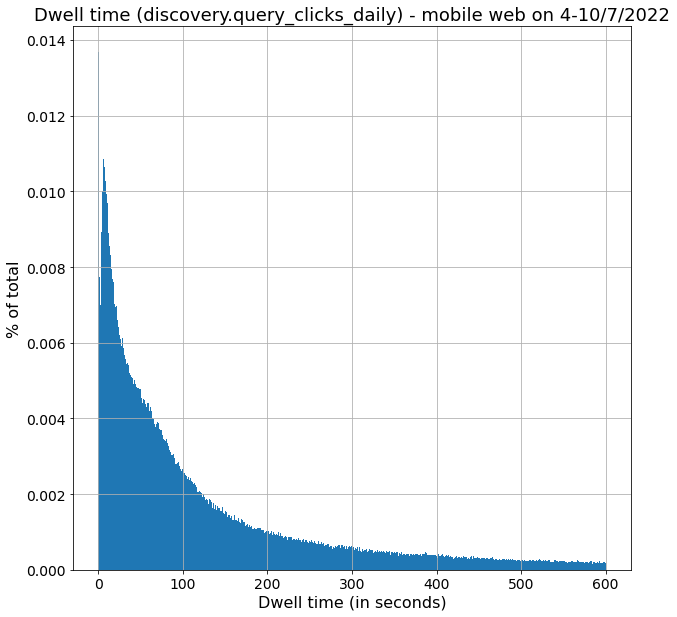

In [46]:
plot_dwell_times_discovery_by_amethod(df_dw, 601, (0,600), "mobile web", 4, 7, 2022, False)

Total dwell times - mobile web 743539


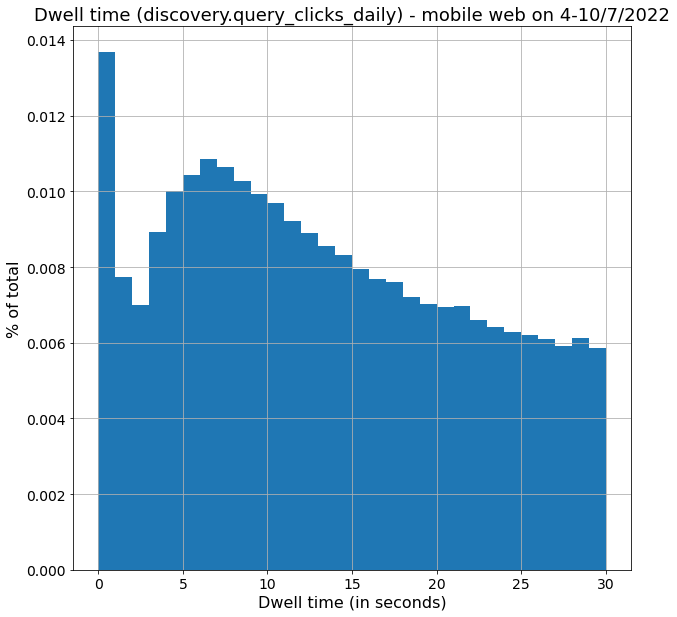

In [47]:
plot_dwell_times_discovery_by_amethod(df_dw, 31, (0,30), "mobile web", 4, 7, 2022, False)

In [35]:
df_clicks_len = spark.read.parquet('dwell-time/df_sessionid_amethod_sizeclicks_4-1072022_r182022.parquet')

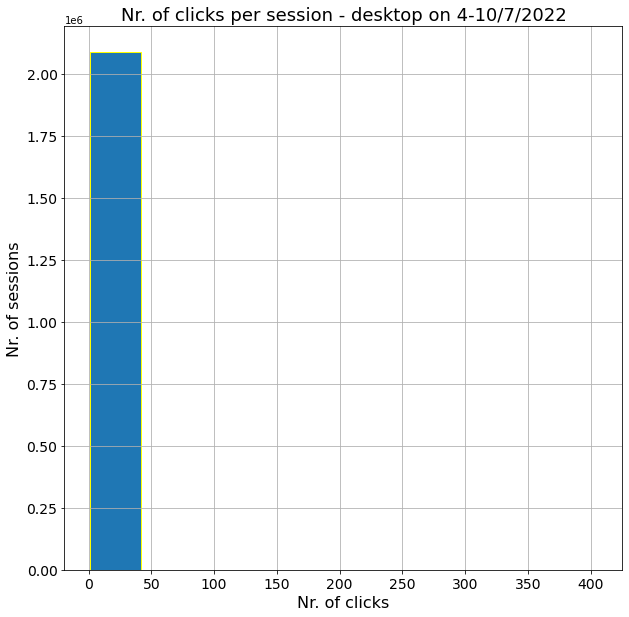

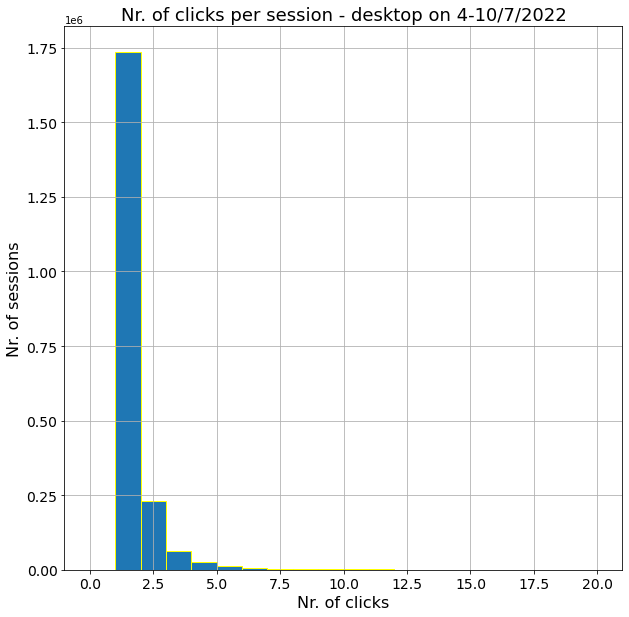

In [38]:
plot_click_dist_discovery_by_amethod(df_clicks_len, 11, (0,20), "desktop", 4, 7, 2022)

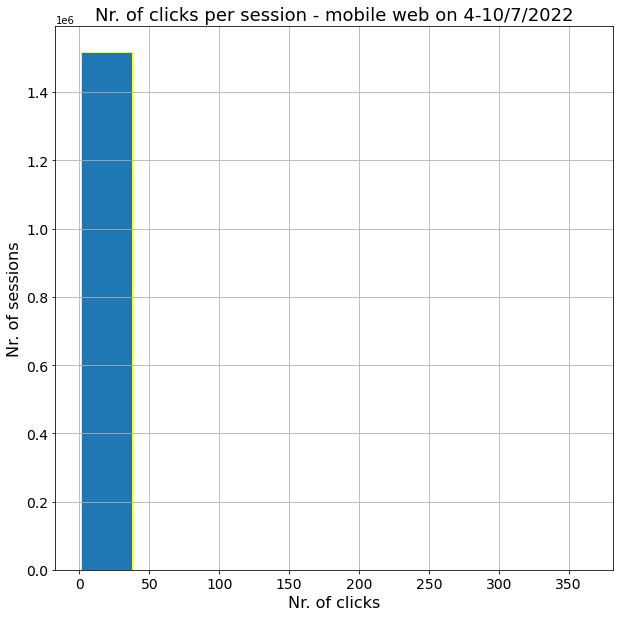

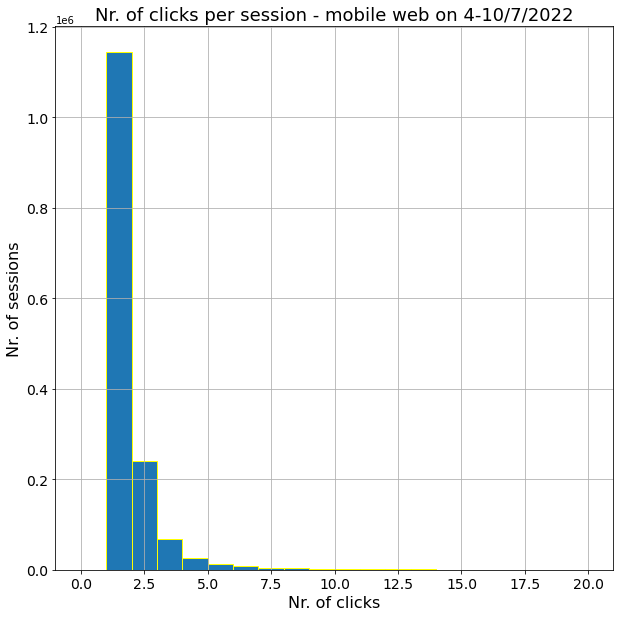

In [39]:
# try:
plot_click_dist_discovery_by_amethod(df_clicks_len, 11, (0,20), "mobile web", 4, 7, 2022)
# except:
#     print("Plotting fail")

### Total nr. of clicks per session - general

In [3]:
df_clicks_len = spark.read.parquet('dwell-time/df_sessionid_amethod_sizeclicks_4-1072022_r182022.parquet')

In [6]:
def plot_click_dist_discovery_general(df_clicks_len, bins, timerange, day, month, year):
    
    pd_df_clicks_len = df_clicks_len.toPandas()

    # pd_df_clicks_len_amethod.hist(column="size_clicks",edgecolor="yellow",figsize=(10,10),log=True)
    pd_df_clicks_len.hist(column="size_clicks",edgecolor="yellow",figsize=(10,10))
    # plt.title(f"Nr. of clicks per session - {access_method} on {day}-{day+6}/{month}/{year} (log scale)", fontsize = 18)
    plt.title(f"Nr. of clicks per session - general on {day}-{day+6}/{month}/{year}", fontsize = 18)
    plt.xlabel("Nr. of clicks", fontsize=16)
    plt.xticks(fontsize=14)
    plt.ylabel("Nr. of sessions", fontsize=16)
    plt.yticks(fontsize=14)
    # plt.savefig(f'/home/bscarone/search-metrics/dwell-time/outputs/clicks_dist_{access_method}_{day}-{day+6}{month}{year}_full_log.pdf')
    plt.savefig(f'/home/bscarone/search-metrics/dwell-time/outputs/clicks_dist_general_{day}-{day+6}{month}{year}_full.pdf')
    
    bins_clicks = list(range(0,21,1))
    bins_clicks[-1] = bins_clicks[-1]-0.01
    # pd_df_clicks_len_amethod.hist(column="size_clicks",bins=bins_clicks,edgecolor="yellow",range=(0,200),figsize=(10,10),log=True)
    pd_df_clicks_len.hist(column="size_clicks",bins=bins_clicks,edgecolor="yellow",range=(0,200),figsize=(10,10))
    # plt.title(f"Nr. of clicks per session - {access_method} on {day}-{day+6}/{month}/{year} (log scale)", fontsize = 18)
    plt.title(f"Nr. of clicks per session - general on {day}-{day+6}/{month}/{year}", fontsize = 18)
    plt.xlabel("Nr. of clicks", fontsize=16)
    plt.xticks(fontsize=14)
    plt.ylabel("Nr. of sessions", fontsize=16)
    plt.yticks(fontsize=14)
    # plt.savefig(f'/home/bscarone/search-metrics/dwell-time/outputs/clicks_dist_{access_method}_{day}-{day+6}{month}{year}_{timerange[0]}-{timerange[1]}_log.pdf')
    plt.savefig(f'/home/bscarone/search-metrics/dwell-time/outputs/clicks_dist_general_{day}-{day+6}{month}{year}_{timerange[0]}-{timerange[1]}.pdf')
    

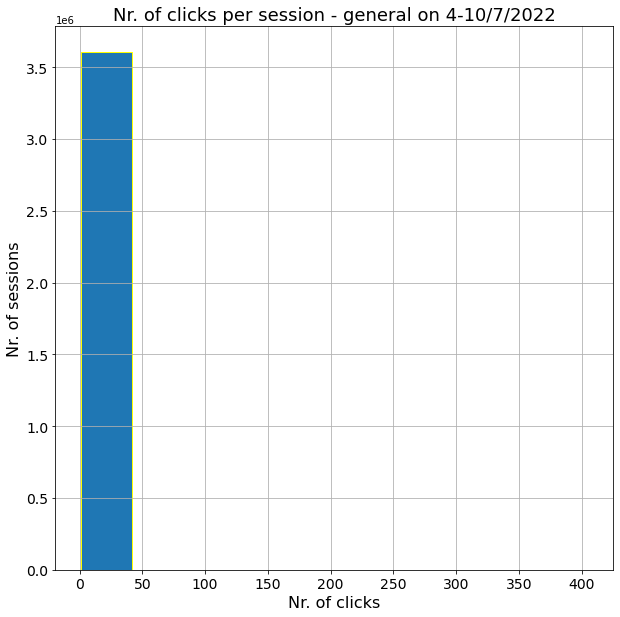

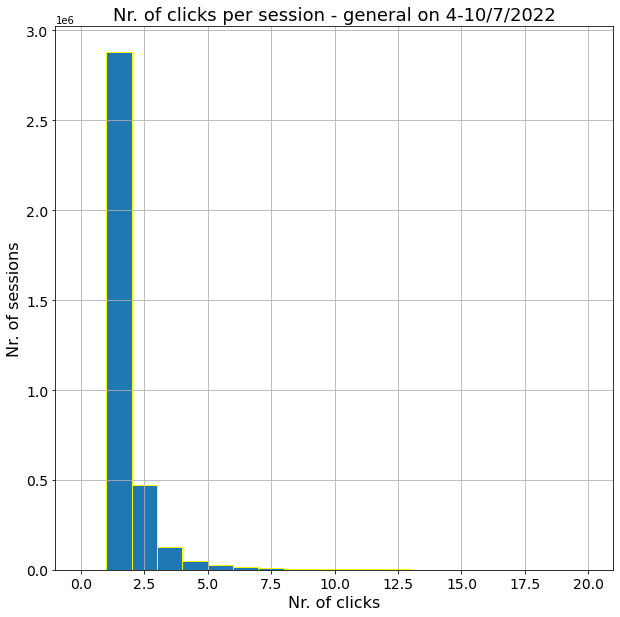

In [7]:
plot_click_dist_discovery_general(df_clicks_len, 11, (0,20), 4, 7, 2022)

In [9]:
df_clicks_len.groupBy("size_clicks").count().orderBy(F.col("size_clicks").desc()).show(20,False) # desc() or asc()

[Stage 4:============================================>          (209 + 8) / 256]

+-----------+-----+
|size_clicks|count|
+-----------+-----+
|405        |1    |
|364        |1    |
|320        |1    |
|307        |1    |
|291        |1    |
|276        |1    |
|274        |1    |
|268        |1    |
|262        |1    |
|255        |2    |
|251        |1    |
|238        |1    |
|231        |1    |
|212        |1    |
|208        |1    |
|200        |1    |
|186        |2    |
|184        |1    |
|179        |2    |
|169        |1    |
+-----------+-----+
only showing top 20 rows



### Dwell times - general

In [10]:
df_dw = spark.read.parquet('dwell-time/df_sessionid_amethod_nonempty_dwelltimes_4-1072022_r182022.parquet')

In [5]:
def plot_dwell_times_discovery_general(df_dw, bins, timerange, day, month, year, is_filtered):
        
    bins = list(range(bins))
    bins[-1] = bins[-1]-0.01 # last interval is not half-closed, so it generates a spike otherwise
    pd_df_dw = df_dw.withColumn("dwell_times", F.explode("dwell_times")).toPandas()
    
    n = pd_df_dw.shape[0]
    print(f'''Total dwell times - general''',n)
    try:
        ws = [1/n]*n
    except:
        ws = None
        
    ax = pd_df_dw.hist(column="dwell_times",bins=bins,range=timerange,weights=ws,figsize=(10,10))
    plt.title("Dwell time (discovery.query_clicks_daily) - general on {}-{}/{}/{}".format(day,day+6,month,year), fontsize = 18)
    plt.xlabel("Dwell time (in seconds)", fontsize=16)
    plt.xticks(fontsize=14)
    plt.ylabel("% of total", fontsize=16)
    plt.yticks(fontsize=14)
    
    if is_filtered:
        plt.savefig(f'/home/bscarone/search-metrics/dwell-time/outputs/dwell_times_general_{day}-{day+6}{month}{year}_{timerange[0]}-{timerange[1]}_filtered.pdf')
    else:
        plt.savefig(f'/home/bscarone/search-metrics/dwell-time/outputs/dwell_times_general_{day}-{day+6}{month}{year}_{timerange[0]}-{timerange[1]}.pdf')


Total dwell times - general 1462964


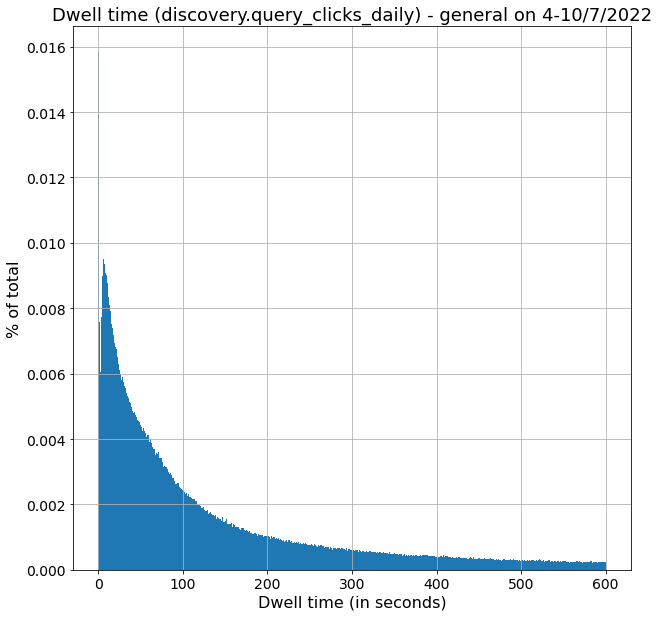

In [15]:
plot_dwell_times_discovery_general(df_dw, 601, (0,600), 4, 7, 2022, False)

Total dwell times - general 1462964


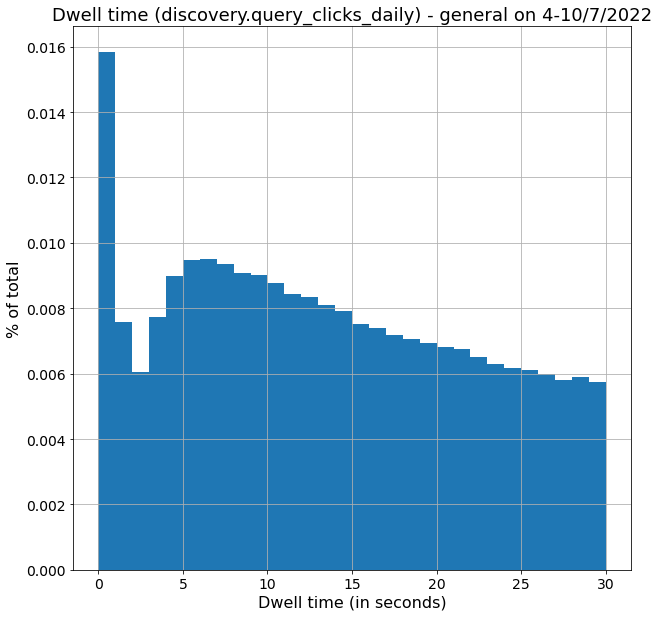

In [16]:
plot_dwell_times_discovery_general(df_dw, 31, (0,30), 4, 7, 2022, False)

In [3]:
df_dw_filtered = spark.read.parquet("dwell-time/df_sessionid_amethod_nonempty_dwelltimes_filtered_4-1072022_r182022.parquet")

Total dwell times - general 809404


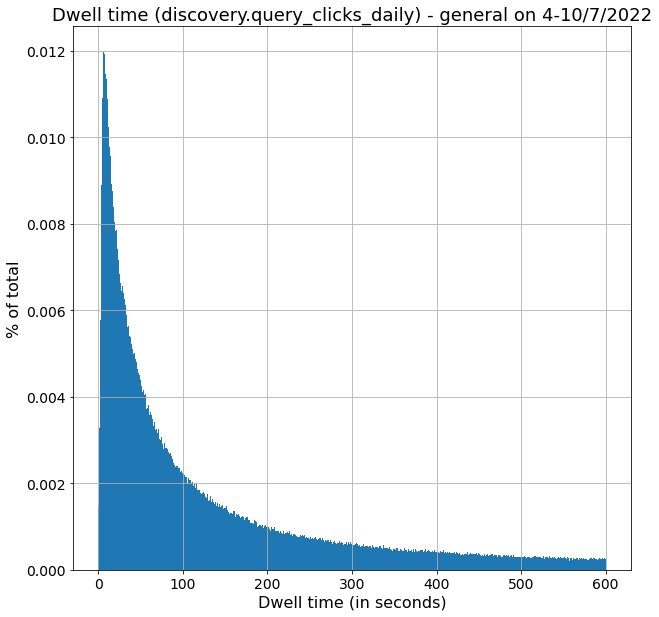

In [6]:
plot_dwell_times_discovery_general(df_dw_filtered, 601, (0,600), 4, 7, 2022, True)

Total dwell times - general 809404


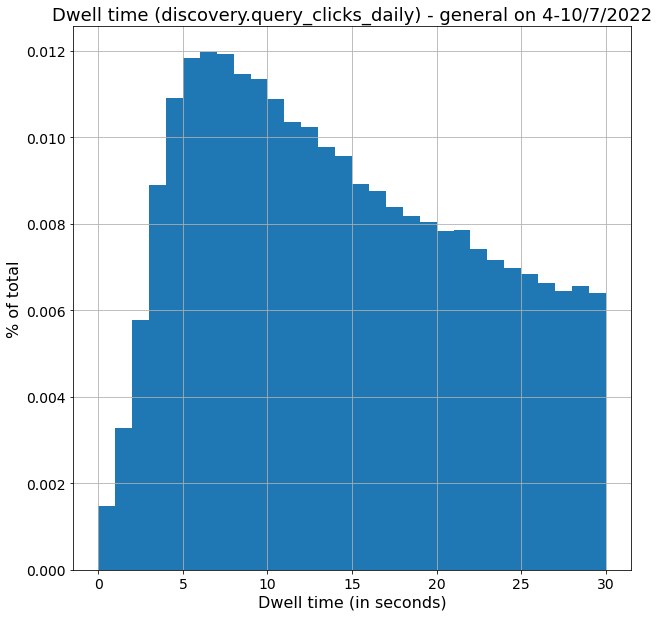

In [7]:
plot_dwell_times_discovery_general(df_dw_filtered, 31, (0,30), 4, 7, 2022, True)

## Filtering multiple consecutive clicks/requests for same resource 

In [8]:
@F.udf() # returnType='array<int>'
def filter_consec_clicks_2(clicks):
    n = len(clicks)
    i = 0
    res = []
    res.append(clicks[0]) # first element is not a duplicate
    while i<n-1: # i=0 -> n-1
        j = i+1
        stop = False
        while j<n and (not stop):
            # check if succesors have same pageid (idx 0) and referer (idx 2)
            if (clicks[i][0] == clicks[j][0]) and (clicks[i][2] == clicks[j][2]):
                # is a duplicate, skip element
                if j == n-1:
                    stop = True
                    i = n-1
                j += 1
            else:
                res.append(clicks[j])
                i = j
                stop = True
    return res
    

In [9]:
# from https://docs.python.org/3/library/itertools.html#itertools.groupby 
# 'The key is a function computing a key value for each element.' 
def keyfunc(c):
    return (c[0],c[2])

In [10]:
@F.udf(returnType=T.ArrayType(T.StructType([T.StructField("pageid", T.IntegerType(), True), T.StructField("timestamp", T.LongType(), True), T.StructField("referer", T.StringType(), True)])))
# StructType([StructField("pageid", IntegerType(), True), StructField("url", StringType(), True)])
def filter_consec_clicks(clicks):
    res = [list(g)[0] for k,g in groupby(clicks, keyfunc)]
    return res

In [24]:
def get_dwell_times_discovery_with_amethod_filtered(year, month, day):
    # Retrieve access_method
    q_amethod = f'''
        WITH query_clicks_daily_aux AS(
            SELECT session_id, clicks, http.request_headers["user-agent"] as user_agent,
            regexp_extract(clicks[0].referer,":\/\/[www.]?([\-a-zA-Z0-9.]+)",1) as uri_host
            FROM event.mediawiki_cirrussearch_request emcr INNER JOIN discovery.query_clicks_daily dqcd
                ON  emcr.search_id = dqcd.request_set_token
            WHERE 
                dqcd.year = {year}  AND dqcd.month = {month} AND dqcd.day BETWEEN {day} and {day+6}
                AND emcr.year = {year}  AND emcr.month = {month} AND emcr.day BETWEEN {day} and {day+6}
        )
        SELECT session_id, clicks, get_access_method(uri_host, user_agent) as access_method
        FROM query_clicks_daily_aux
    '''
    df_amethod = spark.sql(q_amethod)

    # Collect clicks per session
    # The click lists from the same session need to be concatenated
    df_amethod_2 = df_amethod.withColumn("clicks", F.explode("clicks"))
    df_amethod_concat = df_amethod_2.groupBy("session_id","access_method").agg(F.collect_list("clicks").alias("clicks"))
    df_amethod_concat_filtered = df_amethod_concat.withColumn("clicks_filtered", filter_consec_clicks(F.col("clicks")))
    
    # df_amethod_concat_len = df_amethod_concat.withColumn("size_clicks", F.size("clicks")).drop("clicks")
    df_amethod_concat_filtered.printSchema()
    df_amethod_concat_filtered.show(2, False)
    
    df_amethod_concat_filtered_len = df_amethod_concat_filtered.withColumn("size_clicks_filtered", F.size("clicks_filtered")).drop("clicks")

    # Compute dwell times per session
    df_amethod_filtered_dw = df_amethod_concat_filtered.withColumn("dwell_times", dwell_time(F.col("clicks_filtered"))) 
   
    # Filter empty lists (at most 1 click)
    df_amethod_filtered_dw_ne = df_amethod_filtered_dw.select("session_id","access_method","dwell_times").filter(F.size(F.col("dwell_times"))>0)
    
    # write data to hdfs
    today = datetime.date.today()
    df_amethod_concat_filtered_len.write.mode("overwrite").parquet(f'''dwell-time/df_sessionid_amethod_sizeclicksfiltered_{day}-{day+6}{month}{year}_r{today.day}{today.month}{today.year}.parquet''')
    df_amethod_filtered_dw_ne.write.mode("overwrite").parquet(f'''dwell-time/df_sessionid_amethod_nonempty_dwelltimes_filtered_{day}-{day+6}{month}{year}_r{today.day}{today.month}{today.year}.parquet''')
    
    return df_amethod_concat_filtered_len,df_amethod_filtered_dw_ne

In [44]:
# df_clicks_len, df_dw = get_dwell_times_discovery_with_amethod(2022, 5, 2)
df_clicks_len_filtered, df_dw_filtered = get_dwell_times_discovery_with_amethod_filtered(2022, 7, 4)

root
 |-- session_id: string (nullable = true)
 |-- access_method: string (nullable = true)
 |-- clicks: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- pageid: integer (nullable = true)
 |    |    |-- timestamp: long (nullable = true)
 |    |    |-- referer: string (nullable = true)
 |-- clicks_filtered: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- pageid: integer (nullable = true)
 |    |    |-- timestamp: long (nullable = true)
 |    |    |-- referer: string (nullable = true)



+--------------------------------------------+-------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|session_id                                  |access_method|clicks                                                                                                                                                                                                                                                    |clicks_filtered                                                                                                               

In [12]:
df_dw_filtered = spark.read.parquet("dwell-time/df_sessionid_amethod_nonempty_dwelltimes_filtered_4-1072022.parquet")

### Plot results

Total dwell times - desktop 446921


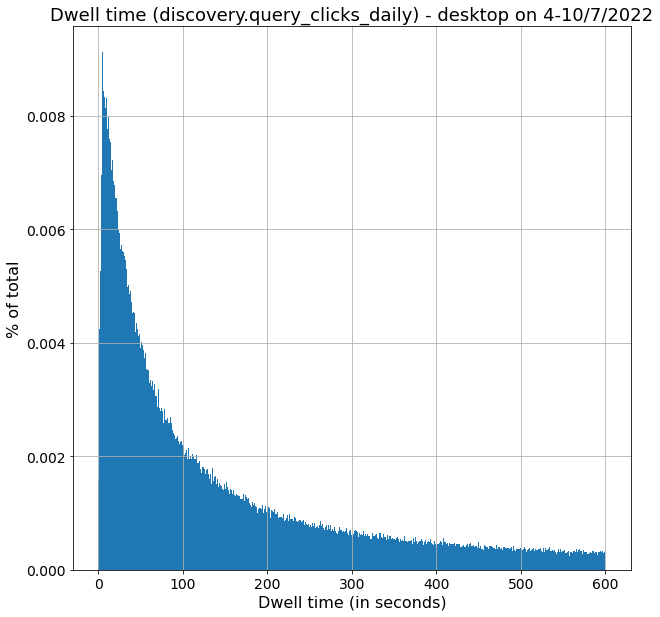

In [45]:
plot_dwell_times_discovery_by_amethod(df_dw_filtered, 601, (0,600), "desktop", 4, 7, 2022)

Total dwell times - desktop 446921


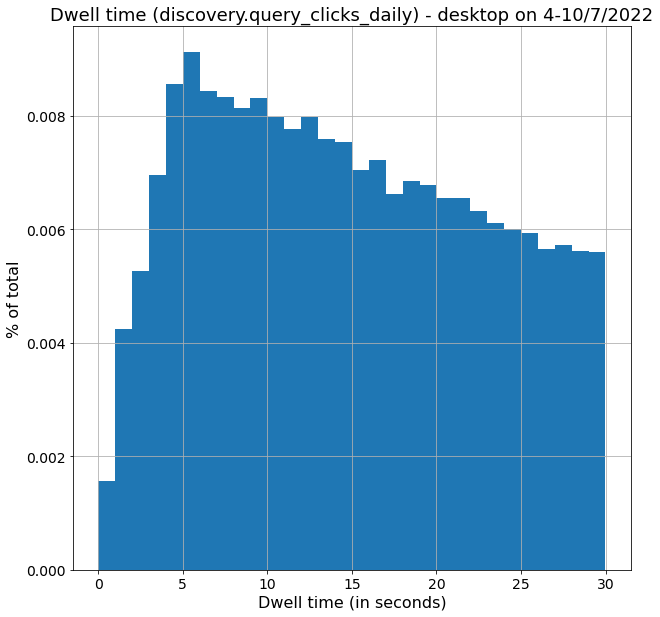

In [13]:
plot_dwell_times_discovery_by_amethod(df_dw_filtered, 31, (0,30), "desktop", 4, 7, 2022)

Total dwell times - mobile web 362483


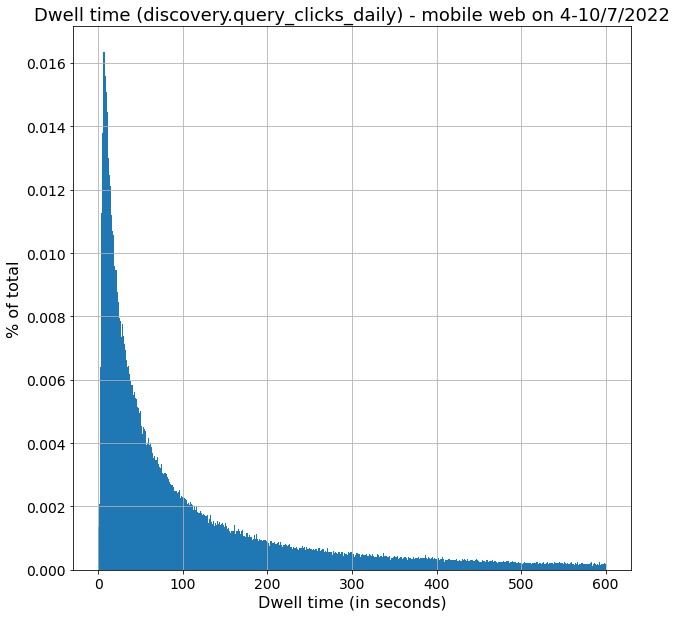

In [46]:
plot_dwell_times_discovery_by_amethod(df_dw_filtered, 601, (0,600), "mobile web", 4, 7, 2022)

Total dwell times - mobile web 362483


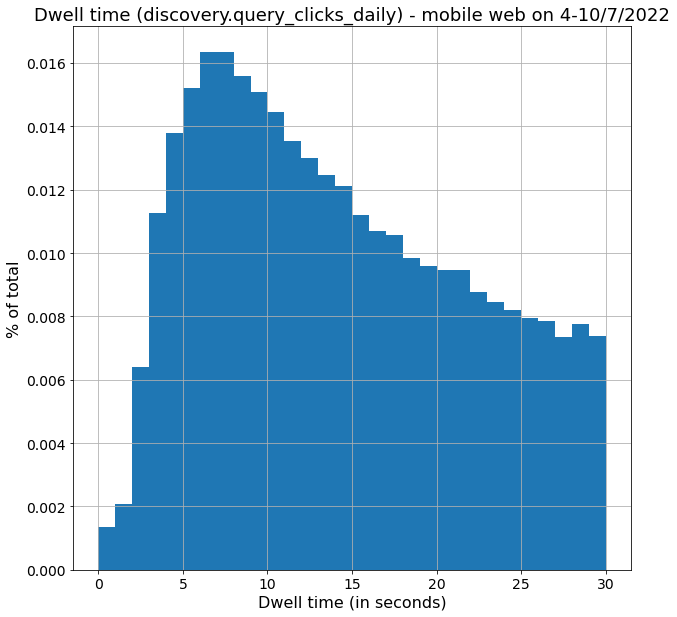

In [14]:
plot_dwell_times_discovery_by_amethod(df_dw_filtered, 31, (0,30), "mobile web", 4, 7, 2022)

#### Tests for `filter_consec_clicks`

In [21]:
def filter_consec_clicks_noudf(clicks):
    res = [list(g)[0] for k,g in groupby(clicks, keyfunc)]
    return res

In [19]:
l1 = [[6448881, 1652843567, 'https://zh.wikipedia.org/w/index.php?search=%E6%96%AF%E8%92%82%E8%8A%AC%E8%AB%BE%E6%96%AF%C2%B7%E8%A5%BF%E8%A5%BF%E5%B8%95%E6%96%AF&title=Special:%E6%90%9C%E7%B4%A2&go=%E5%9F%B7%E8%A1%8C&ns0=1&searchToken=cvqxnx1olno5q6gcde1l5ky76'], [6448881, 1652843807, 'https://zh.wikipedia.org/w/index.php?search=%E6%96%AF%E8%92%82%E8%8A%AC%E8%AB%BE%E6%96%AF%C2%B7%E8%A5%BF%E8%A5%BF%E5%B8%95%E6%96%AF&title=Special:%E6%90%9C%E7%B4%A2&go=%E5%9F%B7%E8%A1%8C&ns0=1&searchToken=cvqxnx1olno5q6gcde1l5ky76']]

In [51]:
l2 = [[1,76767,'a'],[1,76769,'a'],[2,76769,'a']]

In [19]:
# tests consecutiveness
l3 = [[1,76767,'a'],[1,76769,'a'],[2,76769,'a'],[1,86769,'a']]

In [58]:
res = filter_consec_clicks(l)

In [59]:
res

[[6448881,
  1652843567,
  'https://zh.wikipedia.org/w/index.php?search=%E6%96%AF%E8%92%82%E8%8A%AC%E8%AB%BE%E6%96%AF%C2%B7%E8%A5%BF%E8%A5%BF%E5%B8%95%E6%96%AF&title=Special:%E6%90%9C%E7%B4%A2&go=%E5%9F%B7%E8%A1%8C&ns0=1&searchToken=cvqxnx1olno5q6gcde1l5ky76']]

In [68]:
res2 = filter_consec_clicks2(l2)

In [69]:
res2

[[1, 76767, 'a'], [2, 76769, 'a']]

In [22]:
res3 = filter_consec_clicks_noudf(l3)

In [23]:
res3

[[1, 76767, 'a'], [2, 76769, 'a'], [1, 86769, 'a']]

## Count number of sessions with no dwell times (only 1 click)

In [ ]:
# def count_dwell_times_per_session(df):
#     countdf = df.select('*',F.size('dwell_times').alias('dwell_times_cnt'))
#     # countdf.printSchema()
#     countdf.select('dwell_times_cnt').groupby('dwell_times_cnt').count().sort('dwell_times_cnt').show()
#     return 

# can be done by counting How many clicks do not ‘have a dwell time’?
# clicks_with_no_dt = |sessions| - |sessions with 0 clicks|

## How many clicks "have a dwell time"?

In [20]:
def count_clicks_with_dw(df_clicks_len, access_method):
    # an alternative is to call df_clicks_len, _ = get_dwell_times_discovery_with_amethod(year, month, day)
    # instead of receiving it as an argument, changing df_clicks_len for year, month, day 
    
    # df_clicks_len, _ = get_dwell_times_discovery_with_amethod(year, month, day).where(F.col("access_method")==access_method)
    df_clicks_len_am = df_clicks_len.where(F.col("access_method")==access_method)
    
    nr_sessions = df_clicks_len_am.count()
    nr_sessions_zero_clicks = df_clicks_len_am.where(F.col("size_clicks")==0).count()
    clicks_with_dw = nr_sessions - nr_sessions_zero_clicks
    nr_clicks = df_clicks_len_am.agg({"size_clicks": "sum"}).collect()[0][0]
    print(f"Access method is {access_method}")
    print(f"Total number of {access_method} sessions is {nr_sessions}")
    print(f"Number of sessions {access_method} with 0 clicks is {nr_sessions_zero_clicks}")
    print(f"Number of {access_method} clicks 'with *no* dwell time' is {clicks_with_dw}")
    print(f"Number of {access_method} clicks is {nr_clicks}")
    print(f"% of {access_method} clicks 'with *no* dwell time' is {(clicks_with_dw*100)/nr_clicks}")
    return 


In [15]:
# df_clicks_len, df_dw = get_dwell_times_discovery_with_amethod(2022, 5, 2)
df_clicks_len = spark.read.parquet("dwell-time/df_sessionid_amethod_sizeclicks_4-1072022.parquet")

In [21]:
count_clicks_with_dw(df_clicks_len, "desktop")

[Stage 14:==================================================>       (7 + 1) / 8]

Access method is desktop
Total number of desktop sessions is 2088492
Number of sessions desktop with 0 clicks is 0
Number of desktop clicks 'with *no* dwell time' is 2088492
Number of desktop clicks is 2807917
% of desktop clicks 'with *no* dwell time' is 74.37869424203066


In [22]:
count_clicks_with_dw(df_clicks_len, "mobile web")

[Stage 20:==================================================>       (7 + 1) / 8]

Access method is mobile web
Total number of mobile web sessions is 1517301
Number of sessions mobile web with 0 clicks is 0
Number of mobile web clicks 'with *no* dwell time' is 1517301
Number of mobile web clicks is 2260840
% of mobile web clicks 'with *no* dwell time' is 67.11226800658163


# Tests

In [ ]:
# create test df to test plot_dwell_times_discovery_by_amethod
# dataDictionary = [
#         ('James',{'hair':'black','eye':'brown'}),
#         ('Michael',{'hair':'brown','eye':None}),
#         ('Robert',{'hair':'red','eye':'black'}),
#         ('Washington',{'hair':'red','eye':'grey'}),
#         ('Jefferson',{'hair':'red','eye':''})
#         ]
# df = spark.createDataFrame(data=dataDictionary, schema = ["name","properties"])
# df.printSchema()
# df.show(truncate=False)

dataDictionary = [
    ("1", "mobile web", [20,15]),
    ("2", "mobile web", [12,20,3]),
    ("3", "desktop", [1]),
    ("4", "desktop", [])
]
df_test = spark.createDataFrame(data=dataDictionary, schema = ["session_id","access_method","dwell_times"])
df_test.printSchema()
df_test.show(truncate=False)

In [ ]:
df_3 = (
    spark.read.table("discovery.query_clicks_daily")
    .where(F.col("year")==2022)
    .where(F.col("month")==4)
    .where(F.col("day")==18)
).show(1)

In [ ]:
plot_dwell_times_discovery_by_amethod(df_test,51, (0,400), "mobile web", 1, 2, 2022) # weights=(1/df_test.shape[0])*df_test.shape[0]

## Count number of sessions with no dwell times (only 1 click)

In [ ]:
# F.length(F.col("dwell_times")).collect()
# df_test.select(F.length(F.col("access_method"))).show() # this is the length of the content
df_test.count()
# for pandas use baseball_df.shape[0]

In [ ]:
count_dwell_times_per_session(df_test)

In [ ]:
df_test_2 = df_test.withColumn("dwell_times", F.explode("dwell_times")).toPandas()
print(df_test_2)
print(df_test_2.shape)

In [ ]:
# df_test.write.mode("overwrite").parquet("dwell_times_18-2404202")

In [ ]:
# url link
s = 'https://www.geeksforgeeks.org/'
  
# finding the protocol 
obj1 = re.findall('(\w+)://', s)
print(obj1)
  
# finding the hostname which may
# contain dash or dots
obj2 = re.findall('://www.([\w\-\.]+)', s)

print(obj2)

s2 = "https://el.m.wikipedia.org/w/index.php?search=Ομοζυγο&title=Ειδικό:Αναζήτηση&ns0=1"
obj3 = re.findall('://[www.]*([\w\-\.]+)', s2)

print(obj3[0])

In [ ]:
#  check that clicks[0].referer can be accessed using sql
# year = 2022
# month = 5
# day = 2

# '://(\.*)' works; \w does not exist
# q_amethod2 = f'''
#     SELECT clicks[0].referer, regexp_extract(clicks[0].referer,":\/\/[www\.]{0,1}([\-\w\.]+)",1) as REGEXP_SUBSTR
#     FROM discovery.query_clicks_daily
# '''
q_amethod2 = f'''
    SELECT clicks[0].referer, regexp_extract(clicks[0].referer,":\/\/[www.]?([\-a-zA-Z0-9.]+)",1) as REGEXP_SUBSTR
    FROM discovery.query_clicks_daily
'''
# {n,m} does not seem to work
# q_amethod2 = f'''
#     SELECT clicks[0].referer, regexp_extract(clicks[0].referer,"([Mm][o]{1,2})",1) as REGEXP_SUBSTR
#     FROM discovery.query_clicks_daily
# '''
df_amethod2 = spark.sql(q_amethod2)
df_amethod2.show(20,False)

# Rename files/folders in hdfs

In [23]:
# rename folder
def hdfs_rename(old_path, new_path):
    fs = spark._jvm.org.apache.hadoop.fs.FileSystem.get(spark._jsc.hadoopConfiguration())
    fs.rename(
        spark._jvm.org.apache.hadoop.fs.Path(old_path),
        spark._jvm.org.apache.hadoop.fs.Path(new_path)
    )
    return True

In [31]:
# hdfs_rename('dwell-time/df_clicks_distr_4-1072022.parquet','dwell-time/df_clicks_distr_4-1072022_r182022.parquet')
# hdfs_rename('dwell-time/df_sessionid_amethod_nonempty_dwelltimes_4-1072022.parquet','dwell-time/df_sessionid_amethod_nonempty_dwelltimes_4-1072022_r182022.parquet')
# hdfs_rename('dwell-time/df_sessionid_amethod_nonempty_dwelltimes_filtered_4-1072022.parquet','dwell-time/df_sessionid_amethod_nonempty_dwelltimes_filtered_4-1072022_r182022.parquet')
# hdfs_rename('dwell-time/df_sessionid_amethod_sizeclicks_4-1072022.parquet','dwell-time/df_sessionid_amethod_sizeclicks_4-1072022_r182022.parquet')
# hdfs_rename('dwell-time/df_sessionid_amethod_sizeclicksfiltered_4-1072022.parquet','dwell-time/df_sessionid_amethod_sizeclicksfiltered_4-1072022_r182022.parquet')